## Fake data generator

The real data for this project is used from [The Research Productivity of New PhDs in Economics: The Surprisingly High Non-success of the Successful](https://www.aeaweb.org/articles?id=10.1257/jep.28.3.205). This data is available to anyone who wants it, but they must agree to the terms on the website.

As such, I am generating fake data so that someone looking at this repo in isolation can run the code. The data will have the same structure, but will be sampled from arbitrarily fitting distributions.

This fake data has the following properties:

*   AERPub score is sampled from $gamma(0.15, 0.3)$
*   School ranks were sampled uniformly for ranks 1-30, and then at 20x liklihood for 31+
*   Years are sampled uniformly from 1986 to 2000

A gamma distribution was chosen for of its tendency for the probability mass to be near 0 when scale is small. The parameters of $shape=0.15, scale=3$ were chose by eye.

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as sci
import math

In [2]:
columns = ["PhD_ID", "Rank", "Year", "AERPub"]
min_year = 1986
max_year = 2000
num_grads_per_year = 900
num_entries = num_grads_per_year * (max_year - min_year)

# gamma_shape = 0.2
# gamma_scale = 3
base_sigma = 0.5

In [3]:
# Randomly assign IDs
phd_ids = np.arange(num_entries)
np.random.shuffle(phd_ids)

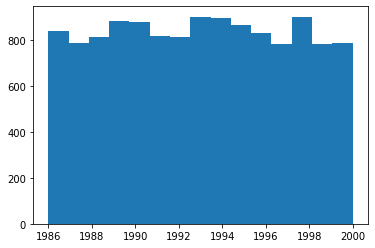

In [4]:
# Uniformly distribute the years
years = np.random.randint(min_year, max_year+1, num_entries)
plt.hist(years, bins = (max_year-min_year + 1));

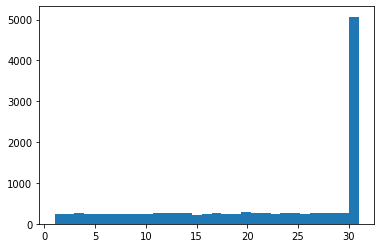

In [5]:
# Distribute the schools.
# Uniformly for the top 30 schools, and about 20x likelihood for the other schools.
school_dist = np.ones(31)
school_dist[30] = 20
school_dist = school_dist / school_dist.sum()
ranks = np.random.choice(np.arange(1,32), replace=True, size=[num_entries], p=school_dist)
plt.hist(ranks, bins=31);

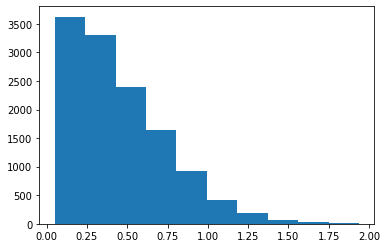

In [11]:
# Get AER ranks from gamma
# aers = np.random.gamma(gamma_shape, gamma_scale, num_entries)
aers_base = sci.halfnorm.rvs(loc=0.05, scale=base_sigma, size=num_entries)
plt.hist(aers_base);

In [13]:
mock_data = pd.DataFrame({"PhD_ID": phd_ids, "Rank": ranks, "Year": years, "AERPub":aers_base})

In [15]:
mock_data.to_csv("fake_data/mock_data.csv", index=False)

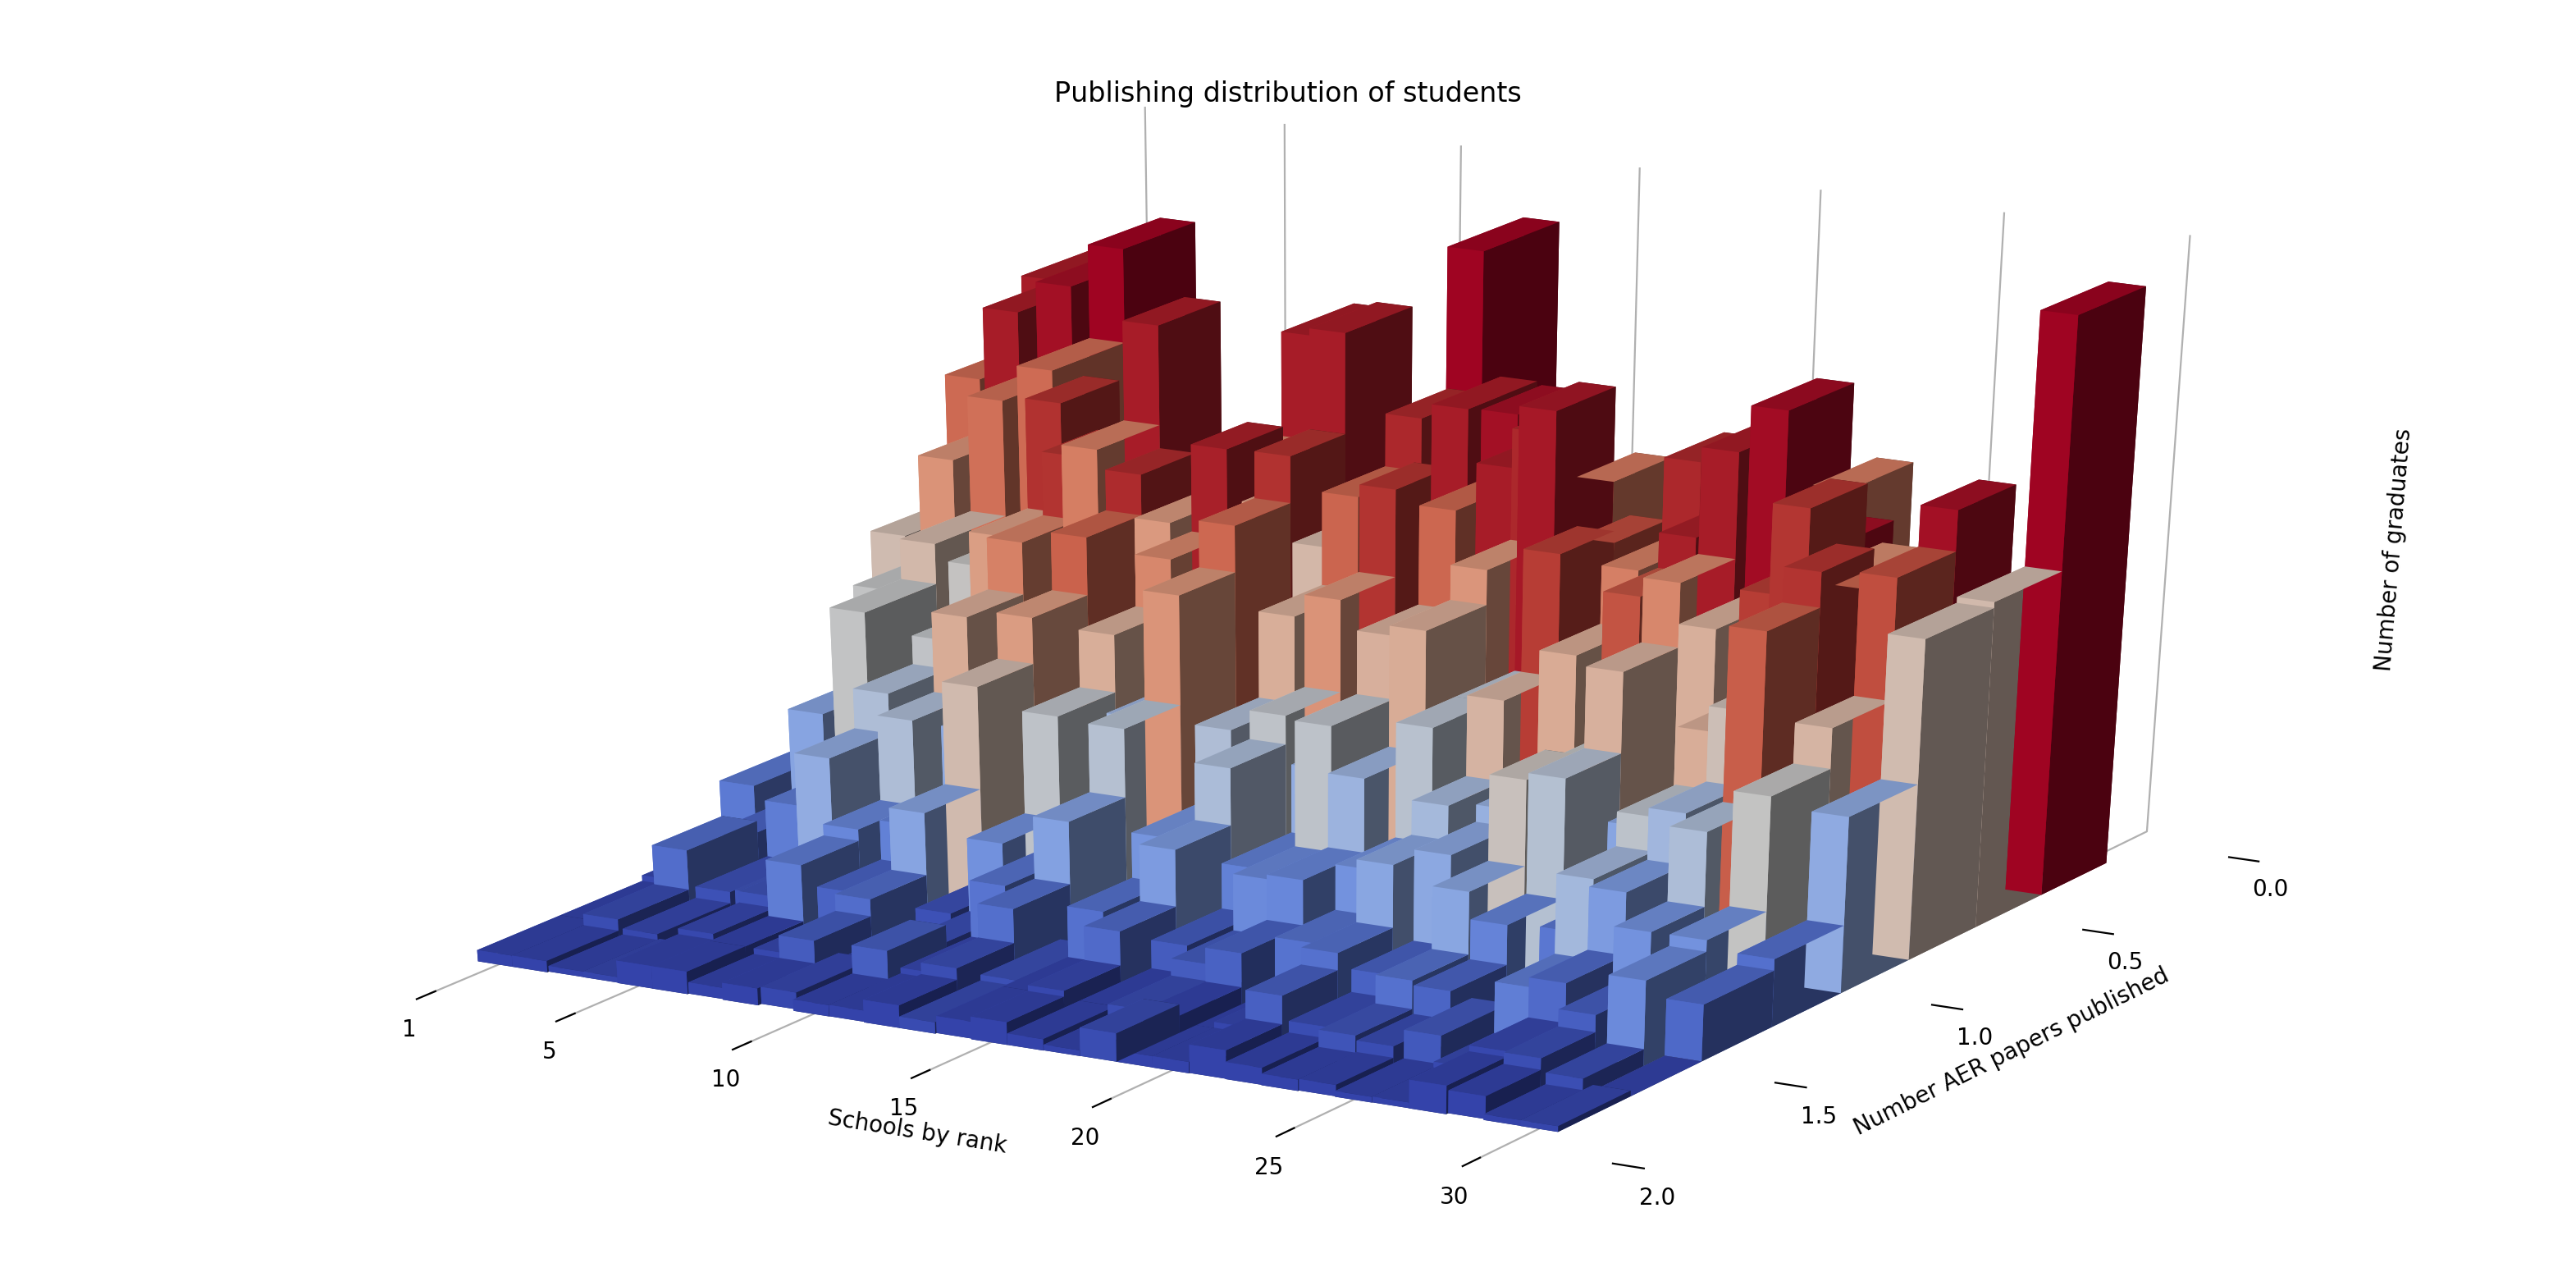

In [330]:
def get_cmap(dz, odd_bit):
    color = ""
    if (odd_bit):
        color = 'summer'
    else:
        color = "spring"
    color = "coolwarm"
    cmap = cm.get_cmap(color)
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((zheight - min_height) / max_height) for zheight in dz] 
    return rgba

def plot_aer_dist(data, targ)
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    fig.set_dpi(200)

    num_bins = 8

    lower_rank = 1
    upper_rank = 31

    for rank in range (lower_rank, upper_rank):
        single_school_d = data[data.Rank == rank]
        y_raw = single_school_d.AERPub

        hist, bin_edges = np.histogram(y_raw, bins=num_bins)
        y_back = bin_edges.flatten()[:-1]
        y = np.flip(y_back)
        x = np.ones(y.size) * rank
        z = np.zeros(y.size)

        # These are bar sizes.
        # Dx is the width on xdim
        # Dy is width on ydim
        # Dz is height on zdim
        dx = 1
        dy = bin_edges[1] - bin_edges[0] # step size
        dz = hist

        odd_bit = rank % 2
        cmap = get_cmap(dz, odd_bit)
        ax.bar3d(x, y, z, dx, dy, dz, color = cmap, alpha=1)


    xticks = [1,5,10,15,20,25,30]
    yticks = [0, 0.5, 1, 1.5, 2]

    xaxis = ax.get_xaxis()
    yaxis = ax.get_yaxis()
    zaxis = ax.get_zaxis()

    # Make grey background transparent
    xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # Make the grid lines transparent
    # xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    # Hide spines
    xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
    yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
    zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    ax.set_title("Publishing distribution of students")
    ax.set_xlabel("Schools by rank")
    ax.set_ylabel("Number AER papers published")
    ax.set_zlabel("Number of graduates")
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels(np.flip(np.array(yticks)))
    ax.set_zticks([]);